Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Import data

In [7]:
data = pd.read_csv('UoB_Set01_2025-01-31LOBs.csv')

# Parse the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Set the 'Time' column as the index
data.set_index('Time', inplace=True)

# Assuming 'Mid-Price', 'Total_volume', 'Bid_ask_spread', and 'Order_imbalance' are your numeric columns
numeric_columns = ['Mid-Price', 'Total_volume', 'Bid_ask_spread', 'Order_imbalance']

# Resample only the numeric columns to 10-minute intervals using the mean for aggregation
data_resampled = data[numeric_columns].resample('1T').mean()

# Reset the index to turn 'Time' back into a column
data_resampled.reset_index(inplace=True)

print(data_resampled.head())

C:\Users\Tim\AppData\Local\Temp\ipykernel_8604\369746167.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time'])


                 Time   Mid-Price  Total_volume  Bid_ask_spread  \
0 2024-03-11 07:30:00  320.581833    113.533333       24.826167   
1 2024-03-11 07:31:00  334.295000    174.116667       33.973000   
2 2024-03-11 07:32:00  316.120167    149.633333        7.626333   
3 2024-03-11 07:33:00  307.861333    144.450000       13.853500   
4 2024-03-11 07:34:00  312.531667    155.683333        6.969667   

   Order_imbalance  
0        -0.080000  
1         0.371833  
2         0.083333  
3         0.003000  
4         0.199000  


C:\Users\Tim\AppData\Local\Temp\ipykernel_8604\369746167.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data[numeric_columns].resample('1T').mean()


Get a df with just time and mid-price

In [8]:
mid_price_df = pd.DataFrame()
mid_price_df['Mid-Price'] = data_resampled['Mid-Price']
mid_price_df.set_index(data_resampled['Time'], inplace=True)

print(type(mid_price_df))
print(mid_price_df.to_string(index=True, header=True))
print(len(mid_price_df))


<class 'pandas.core.frame.DataFrame'>
                      Mid-Price
Time                           
2024-03-11 07:30:00  320.581833
2024-03-11 07:31:00  334.295000
2024-03-11 07:32:00  316.120167
2024-03-11 07:33:00  307.861333
2024-03-11 07:34:00  312.531667
2024-03-11 07:35:00  308.056000
2024-03-11 07:36:00  338.107667
2024-03-11 07:37:00  351.367667
2024-03-11 07:38:00  328.965500
2024-03-11 07:39:00  350.421333
2024-03-11 07:40:00  339.220333
2024-03-11 07:41:00  319.557833
2024-03-11 07:42:00  333.667667
2024-03-11 07:43:00  323.866000
2024-03-11 07:44:00  315.126333
2024-03-11 07:45:00  321.677667
2024-03-11 07:46:00  335.495333
2024-03-11 07:47:00  319.813667
2024-03-11 07:48:00  316.898000
2024-03-11 07:49:00  325.856500
2024-03-11 07:50:00  315.476667
2024-03-11 07:51:00  314.417000
2024-03-11 07:52:00  316.806333
2024-03-11 07:53:00  319.305167
2024-03-11 07:54:00  318.710500
2024-03-11 07:55:00  315.804000
2024-03-11 07:56:00  315.925167
2024-03-11 07:57:00  315.641000
20

Split the data 80:20 by time

                      Mid-Price
Time                           
2024-03-11 14:13:00  300.545333
2024-03-11 14:14:00  299.075667
2024-03-11 14:15:00  299.869667
2024-03-11 14:16:00  294.619833
2024-03-11 14:17:00  287.116333


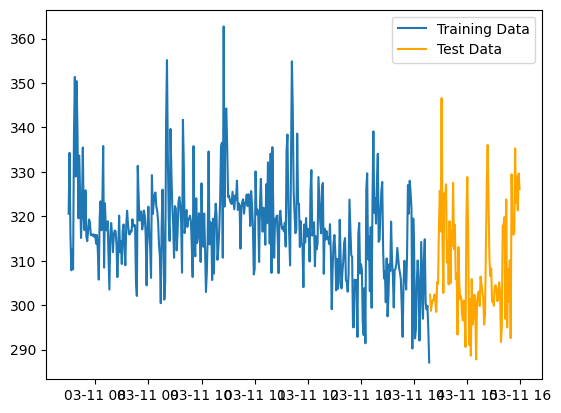

In [9]:
# Get just the mid price
split_index = int(len(data_resampled) * 0.8)


# Split the DataFrame into train and test sets based on the split index
train = (mid_price_df[0:split_index])
test = (mid_price_df[split_index:])

print(train.tail())

plt.plot(train, label = 'Training Data')
plt.plot(test, color = 'orange', label = 'Test Data')
plt.legend()
plt.show()


Do ADF Test to check if data is stationary 

In [10]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(mid_price):
    result=adfuller(mid_price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [11]:
adfuller_test(train['Mid-Price'])

ADF Test Statistic : -4.281264473531307
p-value : 0.00047859376625746273
#Lags Used : 4
Number of Observations Used : 403
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Plot ACF

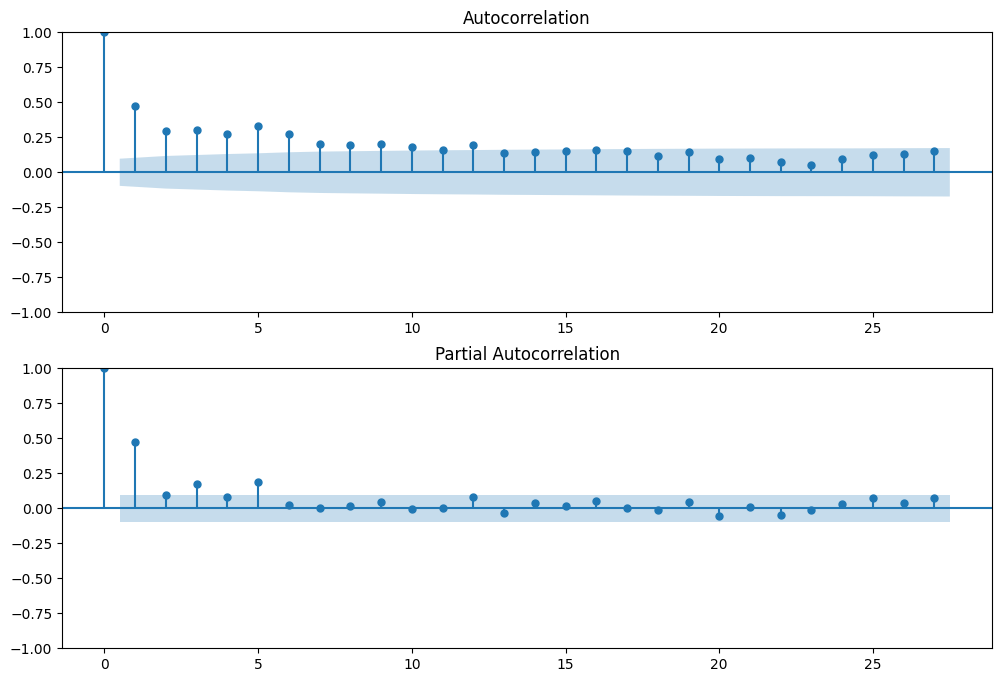

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Use pdarima package to check d calc

In [13]:
from pmdarima.arima.utils import ndiffs 

ndiffs(train, test = "adf")

0

In [14]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

Plot interpretation

ACF Plot Interpretation:

The ACF plot tails off gradually, which indicates that the data may be either an AR process or a mixed ARMA process. In an ACF plot for a pure MA process, we would expect a sharp cut-off after the significant lags. Therefore p = 1.

PACF Plot Interpretation:

The PACF plot shows a significant spike at lag 1, and then it almost immediately cuts off (becomes insignificant). Given the lack of significant spikes in the ACF plot beyond the immediate lag, I will start with q=0 and test q=1 as well.

Differencing Term (d):

As per the ADF test, the data is stationary so d = 0




Do ARIMA Test

In [20]:
print(train)

Time
2024-03-11 07:30:00    320.581833
2024-03-11 07:31:00    334.295000
2024-03-11 07:32:00    316.120167
2024-03-11 07:33:00    307.861333
2024-03-11 07:34:00    312.531667
                          ...    
2024-03-11 15:54:00    335.308667
2024-03-11 15:55:00    323.031000
2024-03-11 15:56:00    328.927833
2024-03-11 15:57:00    321.353500
2024-03-11 15:58:00    329.632500
Name: Mid-Price, Length: 509, dtype: float64


In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Use auto_arima to find the best ARIMA parameters
auto_model = auto_arima(train, seasonal=False, trace=True)
# Print the summary of the best model
print(auto_model.summary())
# Extract the best order
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# Now you can use the best order to fit your ARIMA model
model = ARIMA(train, order=best_order)
model_fit = model.fit()

horizon = 1

# Initialize lists to store predictions and actuals
predictions = []
actuals = []

# Start the cross-validation
for end in range(split_index, len(mid_price_df) - horizon + 1):
    
    # Extract current training data
    train = mid_price_df['Mid-Price'].iloc[:end]
    
    # Fit the ARIMA model
    model = ARIMA(train, order=best_order)  # replace with your order p d q
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=horizon)
    predictions.append(forecast.iloc[0])  # Appending the forecasted value
    
    # Appending the corresponding actual value from the test set
    actuals.append(mid_price_df['Mid-Price'].iloc[end + horizon - 1])  # Adjusted indexing to get the correct actual value




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3712.227, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3886.349, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3815.605, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3734.387, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3884.350, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3714.998, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3717.079, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3713.816, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3718.880, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3716.229, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3720.734, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3717.196, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3720.084, Time=1.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3711.531, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [23]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(actuals, predictions)
print('Test Mean Squared Error:', error)

print(predictions)
print(actuals)

Test Mean Squared Error: 113.55767484792139
[298.42283748483413, 303.6964847422852, 300.58938481181804, 302.4237378595973, 301.36370172860086, 302.17636782265384, 301.92347107024904, 301.64198321868906, 300.59581292458887, 303.2436533385431, 302.5548468152053, 308.2697494832754, 310.95544197995866, 309.10552920714554, 322.1506404214841, 309.1405719771426, 308.64933111434453, 315.08905043520343, 316.2078908627269, 318.68625589867827, 312.00987483482135, 315.3436635245491, 309.4075729393976, 316.67775778495513, 308.7610855377794, 315.9250955118641, 311.6352093310297, 319.76673665606427, 312.2170636254116, 317.1403111088922, 310.28963729410475, 312.57935088632945, 305.08456490855065, 313.0550102096605, 308.2954248960151, 308.2086271240913, 306.85442220341497, 305.6651301442568, 303.961346715274, 305.28556819301514, 303.0215560895328, 299.8386418279914, 310.46592078797556, 314.4166715140782, 311.0294975447913, 301.86279950809933, 305.88846730657593, 299.54481350763444, 306.4636022191395, 3

Plot

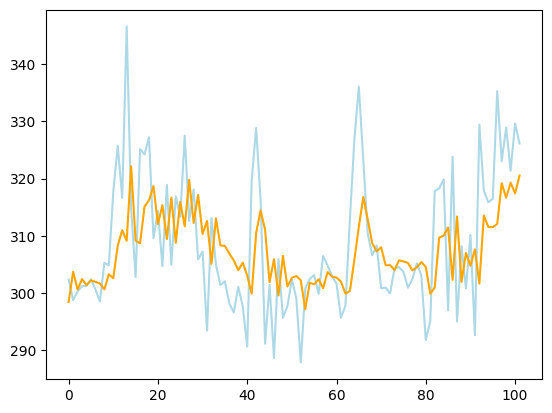

In [24]:
plt.plot(actuals, color = 'lightblue')
plt.plot(predictions, color = 'orange')
plt.show()